# Ataques Adversarios

In [128]:
import tensorflow as tf 
import keras 

import matplotlib.pyplot as plt 
import numpy as np 

In [144]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K 
from keras.preprocessing import image
from PIL import Image

In [130]:
iv3 = InceptionV3()

In [131]:
iv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 149, 149, 32) 96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 149, 149, 32) 0           batch_normalization_752[0][0]    
_______________________________________________________________________________________

## Cargamos una Imagen desde el escritorio, y lo convertimos en una matriz

x.shape muestra las dimensiones de la foto, altura, ancho y profundidad del color (RGB)

In [132]:

x =image.img_to_array(image.load_img("/home/saul12/Escritorio/cheve.jpg"))
x.shape


(600, 280, 3)

## Tenemos que redimensionar la Imagen

In [133]:
x =image.img_to_array(image.load_img("/home/saul12/Escritorio/cheve.jpg",target_size=(299,299)))
x.shape
print(x)

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


## La libreria Inception_v3 usa un formato en el que las matrices solo pueden tomar valores de -1 a 1

In [134]:
x /= 255
x -= 0.5
x *= 2
print(x)

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


## Para usar la libreria inception, necesitaremos una dimension más de nuestra imagen

In [135]:
x = x.reshape([1, x.shape[0], x.shape[1],x.shape[2]])
print(x.shape)

(1, 299, 299, 3)


In [136]:
y = iv3.predict(x)
#numero de dimensiones del tensor
y.shape

/home/saul12/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 1000)

## decode_predictions ordena y clasifica las probabilidades que tiene el tensor

En este caso la red, puede predecir los elementos de la imagen

In [137]:
decode_predictions(y)

[[('n02823428', 'beer_bottle', 0.598648),
  ('n03983396', 'pop_bottle', 0.073663615),
  ('n04131690', 'saltshaker', 0.015682798),
  ('n03062245', 'cocktail_shaker', 0.013072719),
  ('n04579145', 'whiskey_jug', 0.010881099)]]

# Inicio del Ataque Adversario

## Son un tipo de datos de entrada que hace que la red Neuronal se confunda y haga predicciones malas, básicamente lo que se hace es que en lugar de encontrar el minimo error, esto lo hacemos manipulando los pixeles de la imagen de entrada

## Haremos un nuevo grafo para el método de procesamiento de las imagenes de la red Neuronal

In [141]:
tf.compat.v1.disable_eager_execution()
inp_layer = iv3.layers[0].input
out_layer  = iv3.layers[-1].output



target_class = 951
loss = out_layer[0,target_class]


grad = K.gradients(loss, inp_layer)[0]

optimize_gradient = K.function([inp_layer,K.learning_phase()], [grad,loss])

coste = 0.0

adv = np.copy(x)

pert = 0.01

max_pert = x + pert
min_pert = x - pert

while coste < 0.95:
    gr, coste = optimize_gradient([adv, 0])

    adv += gr
    adv = np.clip( adv, min_pert,max_pert)
    adv = np.clip(adv, -1 ,1 )

    print("Limón cost", coste)

Limón cost 0.00016131402
Limón cost 0.00016563255
Limón cost 0.00017040604
Limón cost 0.00017578459
Limón cost 0.00018151184
Limón cost 0.00018769529
Limón cost 0.00019425439
Limón cost 0.00020098133
Limón cost 0.00020813738
Limón cost 0.00021572073
Limón cost 0.00022341993
Limón cost 0.00023119037
Limón cost 0.00023918928
Limón cost 0.00024729618
Limón cost 0.00025582587
Limón cost 0.00026467032
Limón cost 0.00027377415
Limón cost 0.00028293728
Limón cost 0.00029230805
Limón cost 0.00030179886
Limón cost 0.00031123662
Limón cost 0.00032047302
Limón cost 0.00032951462
Limón cost 0.00033844606
Limón cost 0.00034727127
Limón cost 0.00035607218
Limón cost 0.0003646854
Limón cost 0.0003728363
Limón cost 0.0003808267
Limón cost 0.00038858858
Limón cost 0.00039612924
Limón cost 0.00040368442
Limón cost 0.00041132825
Limón cost 0.00041876273
Limón cost 0.00042604803
Limón cost 0.00043345828
Limón cost 0.0004409623
Limón cost 0.00044858715
Limón cost 0.0004560355
Limón cost 0.0004635762
Limón 

In [142]:
adv /= 2
adv += 0.5
adv *= 255


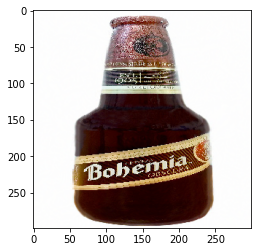

In [143]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [145]:
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./hacked.png")

# Prueba de que la imagen fue hackeada

In [147]:
x =image.img_to_array(image.load_img("/home/saul12/Escritorio/hacked.png",target_size=(299,299)))

x /= 255
x -= 0.5
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1],x.shape[2]])
y = iv3.predict(x)

decode_predictions(y)

[[('n07749582', 'lemon', 0.98956233),
  ('n07747607', 'orange', 0.0047857626),
  ('n07742313', 'Granny_Smith', 0.00046756092),
  ('n03530642', 'honeycomb', 0.0001769943),
  ('n03062245', 'cocktail_shaker', 0.0001746805)]]